In [3]:
import femm
import time
import os
import numpy as np
import cmath
import random
import pandas as pd 
from ipywidgets import IntProgress
from IPython.display import display
from scipy import fftpack
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
femm.openfemm()
femm.opendocument("femm/rogowski_simulation.fem");
femm.mi_saveas("femm/temp.fem")
femm.mi_seteditmode("group")
vr=[];
f=[];

units = "millimeters"
stype = 'planar'
precision = 10**-8
depth = 1
minangle = 30
acsolver = 0 # 0 to successive approximation or 1 to Newton  

init = 0
final = 4

progress = IntProgress(min=init, max=final, description='Simulation:') # instantiate the bar
display(progress) # display the bar

init_time = time.time()

for n in range(init,final): 
    if n == 0:
        n=0.00001
        
    freq = 1000*n
    f.append(freq)
    femm.mi_probdef(freq,units,stype,precision,depth,minangle,(acsolver))
    femm.mi_analyze()
    femm.mi_loadsolution()
    femm.mo_groupselectblock(1)
    v=femm.mo_getcircuitproperties("Ir")
    vr.append(v[1]) # get the voltage drop of Ir
    progress.value = n+1
femm.closefemm()

print('Time: ' + str(time.time() - init_time) + 's')

IntProgress(value=0, description='Simulation:', max=4)

Time: 22.85573720932007s


Text(0.5, 0, 'Frequency [Hz]')

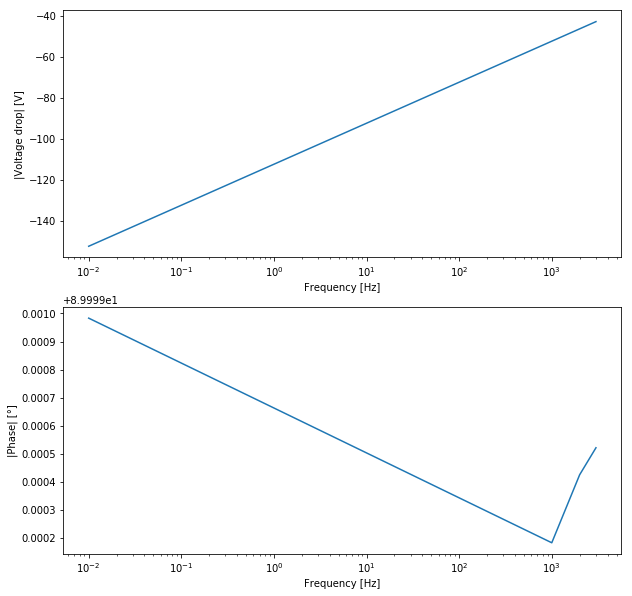

In [4]:
# Plot of Rogowski coil frequency response 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(f,20*np.log10(np.abs(vr)/100))
ax[0].set_ylabel('|Voltage drop| [V]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(f,np.angle(vr)*180/np.pi)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

In [5]:
# gain of Rg Coil
gain = np.abs(vr[-1])/(100*f[-1])
gain

2.442818970228452e-06

In [87]:
# read file
file_data = pd.read_csv('../../../../../../vibration-analysis/datasets/MotorDesbalanceado.csv')
    
# get set of data from .csv file
data = 330*file_data['Amperimeter']
len_data = len(data)
   
init = 0.5
final = 0.55

# sample Rate in Hz
f_s = 10000

data_plot = data[int(init*len_data+1):int(final*len_data)]
fft_data = fftpack.fft(data_plot)
amplitude = np.abs(fft_data)
phase = np.angle(fft_data)
freqs = fftpack.fftfreq(len(data_plot)) * f_s

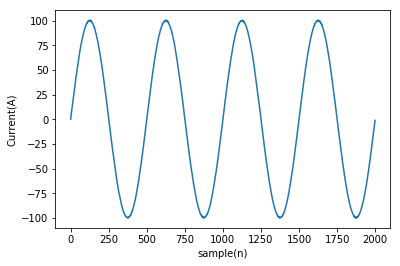

In [88]:
# create a signal with white noise
Fs = 10000
f = 20
x = np.arange(len_data)
noise = 2e-8*np.asarray(random.sample(range(0,len_data),len_data))
 
y_noise = 100*(np.sin(2 * np.pi * f * x / Fs)+noise)
plt.plot(y_noise[0:2000])
plt.ylabel('Current(A)')
plt.xlabel('sample(n)')
plt.show()

data_plot_sml = y_noise[int(init*len_data+1):int(final*len_data)]
fft_data_sml = fftpack.fft(data_plot_sml)
amplitude_sml = np.abs(fft_data_sml)
phase_sml = np.angle(fft_data_sml)
freqs_sml = fftpack.fftfreq(len(data_plot_sml)) * f_s

In [90]:
# Calculates the Rogowski voltage from the product between Rogowski coil frequency response and 
# the currente imported from another sensor
AmplReal = []
PhsReal = []
polarReal = []

AmplSml = []
PhsSml = []
polarSml = []

for n in range(0, len(freqs)):
    AmplReal.append(amplitude[n]*gain*freqs[n])
    PhsReal.append(phase[n]*(180/np.pi) + 90)
    polarReal.append(cmath.rect(AmplReal[n], PhsReal[n]))
    
    AmplSml.append(amplitude_sml[n]*gain*freqs_sml[n])
    PhsSml.append(phase_sml[n]*(180/np.pi) + 90)
    polarSml.append(cmath.rect(AmplSml[n], PhsSml[n]))

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Frequency [Hz]')

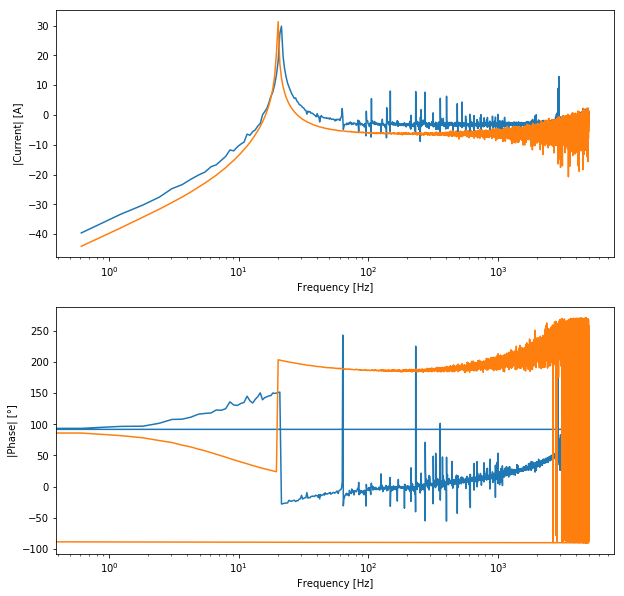

In [91]:
# Rogowski voltage Frequency response of a real current
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(freqs,20*np.log10(AmplReal), freqs_sml,20*np.log10(AmplSml))
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(freqs,PhsReal, freqs_sml,PhsSml)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

(-0.025, 0.025)

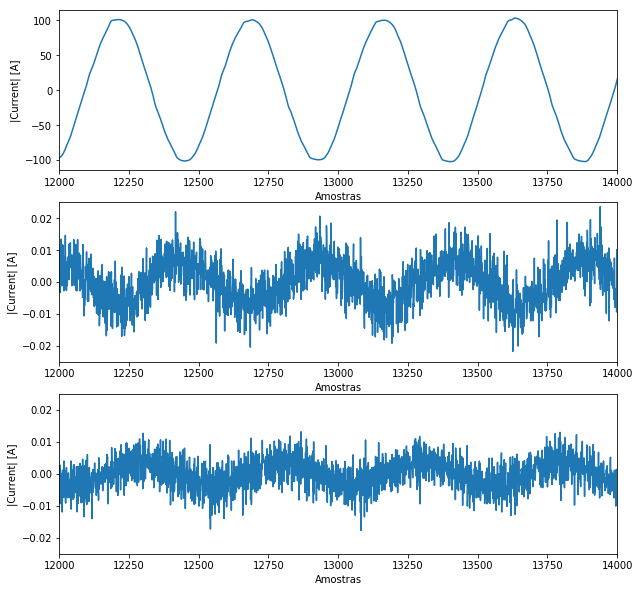

In [92]:
# inverse fft of the Rogowski voltage of a real current
signal_rogowski_real = fftpack.ifft(polarReal)
signal_rogowski_sml = fftpack.ifft(polarSml)

# plot and compare ifft with a real current
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
ax[1].plot(signal_rogowski_real)
ax[1].set_ylabel('|Current| [A]')
ax[1].set_xlabel('Amostras')
ax[1].set_xlim(12000, 14000)
ax[1].set_ylim(-0.025, 0.025)

ax[0].plot(data)
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Amostras')
ax[0].set_xlim(12000, 14000)

ax[2].plot(signal_rogowski_sml)
ax[2].set_ylabel('|Current| [A]')
ax[2].set_xlabel('Amostras')
ax[2].set_xlim(12000, 14000)
ax[2].set_ylim(-0.025, 0.025)

In [93]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = 1000000000*(np.real(signal_rogowski[10000: 14000]))
iwave = wave.astype(int)

wavfile.write('ltspice/vRogowski.wav', sampleRate, iwave)

In [94]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = 1000000000*(np.real(signal_rogowski_sml[10000: 14000]))
iwave = wave.astype(int)

wavfile.write('ltspice/vRogowskiSml.wav', sampleRate, iwave)

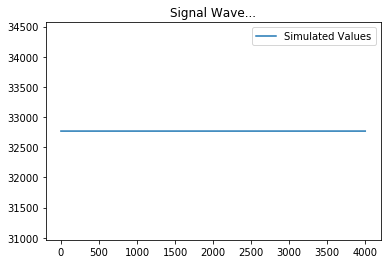

In [110]:
# imports a wav file from a LTspice simulation and compare with de  signal with white noise
wav_data = wavfile.read('ltspice/output3.wav', sampleRate)
init = 0
final = 4000
plt.figure(1)
plt.title('Signal Wave...')
plt.plot(wav_data[1][init:final], label='Simulated Values')
#plt.plot(y_noise[init:final], label='Real Current')
plt.legend()
plt.show()

In [104]:
# imports a wav file from a LTspice simulation and compare with de real current signal
wav_data = wavfile.read('ltspice/output4.wav', sampleRate)

plt.figure(1)
plt.title('Signal Wave...')
plt.plot(wav_data[1][2000:4000]/100, label='Simulated Values')
plt.plot(data[0:2000], label='Real Current')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'ltspice/output4.wav'

In [21]:
filename = "ltspice/MC_AC_AnalogRogowskiSignalProc.txt"
with open(filename, 'r') as infile:
    for i in range(1, 5):
        data = infile.read()
        print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
data = []
with open ("ltspice/MC_AC_AnalogRogowskiSignalProc.txt", "r") as myfile:
    for line in  myfile:
        data.append(line)    

In [22]:
a = data[2].split("	")
print(int(a[0]))
b = a[1].split("dB,")
print(b)

ValueError: invalid literal for int() with base 10: '1.00000000000000e-001'

1.915586396909372


In [68]:
import cmath
import math
import numpy as np

# tolerância de 0.1% para resitor e 1% capacitor
a = 10**(33.392/20)
b = 10**(33.56/20)
gain = 1000*0.047239

print('Dif entre min e max: '+ str((b-a)/b*100))
print('Menor Simulado: ' + str(a))
print('Maior Simulado: ' + str(b))
print('Calculado: ' + str(gain))

print('Erro max: ' + str(((gain-a)/gain)*100))
print('Erro min: ' + str(((b-gain)/b)*100))

Dif entre min e max: 1.915586396909372
Menor Simulado: 46.73045396315102
Maior Simulado: 47.643098680541584
Calculado: 47.239000000000004
Erro max: 1.0765385314019842
Erro min: 0.848178837508363


In [69]:
# tolerância de 0.01% para resitor e 1% capacitor
a = 10**(33.559/20)
b = 10**(33.401/20)
gain = 1000*0.047239

print('Dif entre min e max: '+ str((b-a)/b*100))
print('Menor Simulado: ' + str(a))
print('Maior Simulado: ' + str(b))
print('Calculado: ' + str(gain))

print('Erro max: ' + str(((gain-a)/gain)*100))
print('Erro min: ' + str(((b-gain)/b)*100))

Dif entre min e max: -1.8356875719783778
Menor Simulado: 47.63761388183771
Maior Simulado: 46.778899438536236
Calculado: 47.239000000000004
Erro max: -0.8438237088797482
Erro min: -0.9835643142231343


In [70]:
# tolerância de 0.01% para resitor e 0.1% capacitor
a = 10**(33.490/20)
b = 10**(33.474/20)
gain = 1000*0.047239

print('Dif entre min e max: '+ str((b-a)/b*100))
print('Menor Simulado: ' + str(a))
print('Maior Simulado: ' + str(b))
print('Calculado: ' + str(gain))

print('Erro max: ' + str(((gain-a)/gain)*100))
print('Erro min: ' + str(((b-gain)/b)*100))

Dif entre min e max: -0.18437657240267172
Menor Simulado: 47.260683689833904
Maior Simulado: 47.17370642684878
Calculado: 47.239000000000004
Erro max: -0.045902093257477246
Erro min: -0.13841094562385567


In [71]:
# tolerância de 0.1% para resitor e 0.1% capacitor
a = 10**(33.494/20)
b = 10**(33.468/20)
gain = 1000*0.047239

print('Dif entre min e max: '+ str((b-a)/b*100))
print('Menor Simulado: ' + str(a))
print('Maior Simulado: ' + str(b))
print('Calculado: ' + str(gain))

print('Erro max: ' + str(((gain-a)/gain)*100))
print('Erro min: ' + str(((b-gain)/b)*100))

Dif entre min e max: -0.2997845198331394
Menor Simulado: 47.28245305117965
Maior Simulado: 47.14113123725613
Calculado: 47.239000000000004
Erro max: -0.09198554410475815
Erro min: -0.207608006374113
